![breakdance-segment](https://i.imgur.com/sAPM7Yy.png)

# Score Your Results With This Notebook

Run this notebook
in order to prepare your results
for submission to the public leaderboard.
You'll only want to do this once you've
trained a model and then
produced an artifact storing the result
of running that model on the validation set
in order to submit your score and predictions to the leaderboard.
For examples of how to do this,
check out the starter Colabs
([PyTorch/Lightning](http://wandb.me/davis-starter-pt)
[TensorFlow/Keras](http://wandb.me/davis-starter-keras))

This notebook will collate your predictions,
evaluate them against a ground truth (also stored in an artifact),
and upload the outputs and score to Weights & Biases as an artifact.

Once you've done that,
you can confirm the submission looks good
before officially submitting it to the public leaderboard,
as detailed at the end of this notebook.

As written, this script evaluates performance against
the validation set, to which you have access.
Final scores will be calculated by using this same script,
but with the ground truth Artifact switched out for the private test set.

In [ ]:
%%capture
!pip install git+https://github.com/wandb/davis-contest.git#egg=contest

In [ ]:
import wandb

import contest
from contest.utils import paths

## Scoring

To evaluate your results, we need the identity of the Artifact where your results are stored.

The results Artifact should contain
- At the top level, a `paths.json` file with key `output`. The value associated with this key is a list of paths.
- All of the files indicated by the paths in the list.

You can generate a results Artifact from saved model outputs
with `contest.evaluate.make_result_artifact`.

The outputs be checked, in order, against the annotations for an associated ground truth dataset Artifact.
During the competition, that's the validation set.
After the competition, when your submission
is getting its final score, that's the test set.

See the example starter notebooks,
linked in [the table in the repo README](https://github.com/wandb/davis-contest)
for more on generating properly-formatted results.

**If you're not sure what the identity of your result Artifact is**, the screenshot collage below shows you where to find this information (circled in gold) on the API page (link circled in blue) of the Artifact.

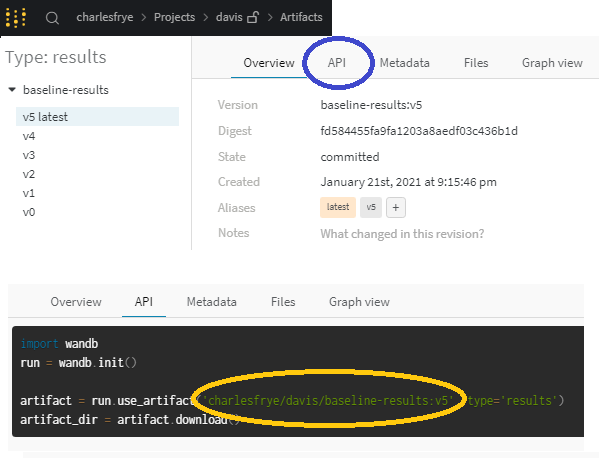

In [ ]:
# this is where you should put your result's ID

result_artifact_id = "charlesfrye/davis/simple-decoder-result:latest"

In [ ]:
mode = "val"
tag = "contest"
ground_truth_artifact_id = f"wandb/davis/davis2016-{mode}" + ":" + tag

In [ ]:
def run_evaluation(run, result_artifact_id, ground_truth_artifact_id, mode="val"):
  # fetch the results and the paths to the model outputs
  result_artifact = run.use_artifact(result_artifact_id)
  contest.evaluate.check_result_artifact_metadata(result_artifact.metadata)
  run.log(result_artifact.metadata)

  output_paths = paths.artifact_paths(result_artifact, "output")
  
  # fetch the dataset and the paths to the ground truth annotations
  ground_truth_artifact = run.use_artifact(ground_truth_artifact_id)
  annotation_paths = paths.artifact_paths(ground_truth_artifact, "annotation")

  # evaluate metrics and log them to W&B
  evaluation, metrics = contest.evaluate.run_evaluation(output_paths, annotation_paths)
  run.log(metrics)

  # package the evaluation into an Artifact containing a Table
  evaluation_artifact_name = contest.evaluate.name_submission(result_artifact.name)
  evaluation_artifact = wandb.Artifact(evaluation_artifact_name,
                                       type="submission")
  evaluation_table = contest.evaluate.build_table(evaluation)
  evaluation_artifact.add(evaluation_table, f"{mode}-eval-data")

  # submit the evaluation to W&B
  run.log_artifact(evaluation_artifact)

The critical function for scoring is `contest.evaluate.run_evaluation`.

Check out the doc string below:

In [ ]:
print(contest.evaluate.run_evaluation.__doc__)

The `"segmentation_metric"` key is used to determine position on the leaderboard,
and the same metric on the test set will be used
to determine the winners.

See the
[contest repo](https://github.com/wandb/davis-contest)
for details on how results are scored.

In [ ]:
contest_project = "davis"  # can change this to where you're storing results

with wandb.init(project=contest_project, job_type=f"{mode}-eval") as run:
  run_evaluation(run, result_artifact_id, ground_truth_artifact_id, mode=mode)
  run_path = run.path

### Reviewing your submission

Expand this section for information on how you can review your submission
in detail
-- visualizing what your model produced
and checking the score
on every single example inside
an interactive database/table,
complete with filtering, sorting, and other tools.

After running the cell below,
you can confirm that your results look right
by checking your submission artifact.

Head to the run page
(link will be generated when you execute the cell above)
and to the Artifacts tab --
the one with the [database icon](https://stackoverflow.com/questions/2822650/why-is-a-database-always-represented-with-a-cylinder).

You should see a page that looks like this:

![submission-artifacts-tab](https://i.imgur.com/depgvoZ.png)

The "Output artifacts" will include your submission.

Click on it, then navigate to the "Files" tab inside the artifact (right side of the screen, towards the top) and look for a file whose name ends with `.table.json`, as below:

![submission-files-tab](https://i.imgur.com/EYo8ZZE.png)

Click on the file and you'll be brought to an interactive data viewer,
using Weights & Biases' new
[Datasets and Predictions visualization tools](https://docs.wandb.ai/datasets-and-predictions).

You can review your results in detail,
seeing your score on every frame and making sure everything looks right.
If the results don't look like they're lined up properly,
make sure that you confirm you're construcing your `paths.json` file correctly,
as described in the
[contest instructions](https://github.com/wandb/davis-contest).

Reach out via the Slack channel, `#qualcomm-competition`,
([join here](http://wandb.me/Slack))
or email contest@wandb.com.

![submission-dsviz](https://i.imgur.com/C9fpeeg.png)

## Submitting to the Leaderboard

Once you've run an evaluation on your results
and created a submission artifact
that you're happy with,
you can officially submit the run to the
public leaderboard on the
[Weights & Biases benchmark for the contest](http://wandb.me/davis-benchmark).

Click the "Submit a run" tab on the right side of the benchmark page
and then paste or type in the
W&B run path for the run
you used to score your submission.
Click the "Submit" button
to start the submission process.
Submissions are manually reviewed
before they are accepted.

If you ran the cells above to execute your run, the run_path will be printed by the cell below.

See the instructions on the
"Submit a run" tab
for more on run paths.

In [ ]:
run_path